In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import pickle
from pathlib import Path
import math
from qutip import *
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit

plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':20})
plt.rcParams['text.usetex'] = True

In [2]:
# csv_fileD = "qb_timeseries_allD=cke.csv"
def extract_data_alpha(what, ws_val, r_val):
    csv_filename = "qb_timeseries_fits.csv"
    df = pd.read_csv(csv_filename)
    # Filter rows matching chi, g, r
    filtered = df[(df['ws'] == ws_val) & (df['r'] == r_val)]
    return filtered[what].values[0]

def extract_data_for_N(csv_filename, ws_val, an_val, gb_val):
    df = pd.read_csv(csv_filename)
    # Filter rows matching chi, g, r
    filtered = df[(df['ws'] == ws_val) & (df['an'] == an_val) & (df['gb'] == gb_val)]
    return filtered

def rescale_vals(y):
    return np.exp(np.log(y)-np.log(y[0]))

def E_N(N,a,b):
    return b*N**a

def fit_N(x,y):
    popt, _ = curve_fit(E_N, x, y, p0=[1.0, 1.0], maxfev=10000)
    return popt

In [3]:
from matplotlib import colors as mcolors
import colorsys

def man_cmap(cmap, value=1.):
    colors = cmap(np.arange(cmap.N))
    hls = np.array([colorsys.rgb_to_hls(*c) for c in colors[:,:3]])
    hls[:,1] *= value
    rgb = np.clip(np.array([colorsys.hls_to_rgb(*c) for c in hls]), 0,1)
    return mcolors.LinearSegmentedColormap.from_list("", rgb)

cmap = plt.get_cmap('coolwarm')
cmap = man_cmap(cmap,0.7)

In [4]:
ws_list  = np.round(np.linspace(0.0,1,11),2)
gb_grid   = np.linspace(0.0, 2.0, 21)
N_list   = np.arange(1,71,1)
anis_list = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
gc = 0.05

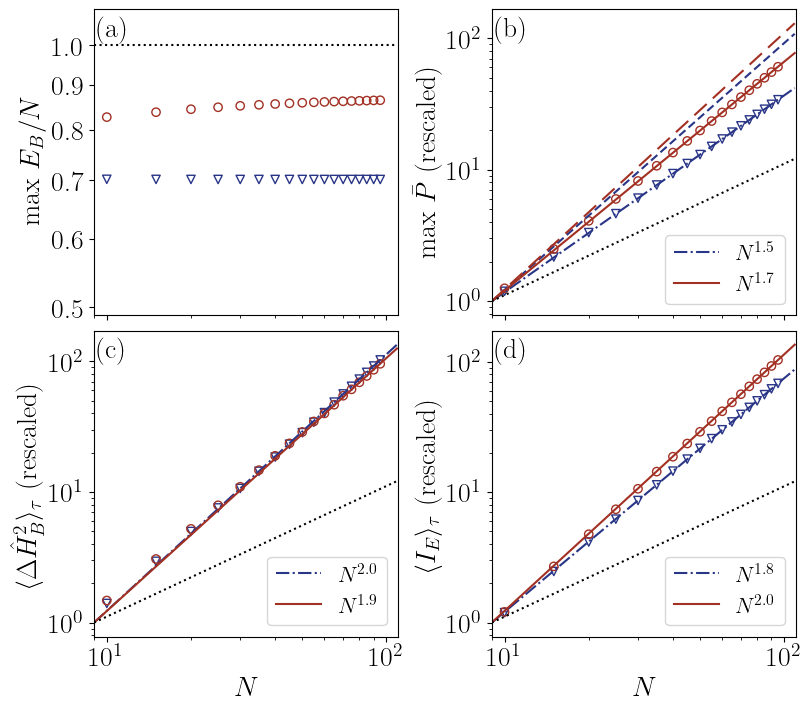

In [17]:
csv_file = "qb_timeseries_an-1.csv"

fig, axes = plt.subplots(2, 2, figsize=(8,7),sharex=True,layout='constrained')
axes = axes.flatten()
fsize = 20
etp = 110
start = 9

labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axes, labels):
    ax.text(0.01, 0.98, label, transform=ax.transAxes, fontsize=fsize, 
            verticalalignment='top',)# fontweight='bold',)
            #bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # ax.axvspan(100,etp,color='orange',alpha=0.2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim((start,etp))

axes[3].set_xlabel(r'$N$',fontsize=fsize)  
axes[2].set_xlabel(r'$N$',fontsize=fsize)
axes[0].set_ylim((4.9e-1,1.1))

ws_val = [0.0, 0.0]
gb_val = [0.0, 2.0]
an_val = -1.0
color = [cmap(0),cmap(0.9)]
marker = ['v','o']
linestyle = ['-.', '-']
end = -1
mev=5
for i, (ws, gb) in enumerate(zip(ws_val,gb_val)):
    result_df = extract_data_for_N(csv_file, ws, an_val, gb)
    Nvals = result_df['N'].values[start:end]
    Evals = result_df['Emax'].values[start:end]
    Pvals = result_df['Pavgmax'].values[start:end]
    HBvals = result_df['HBavg'].values[start:end]
    IEvals = result_df['IEavg'].values[start:end]
    
    St_fit = 74
    Nfit = np.arange(start,etp)

    Ep = fit_N(Nvals[St_fit:],Evals[St_fit:])
    Efit = E_N(Nfit,Ep[0],Ep[1])/(Nfit)
    # axes[0].plot(Nfit,Efit, linestyle=linestyle[i], color=color[i], label=f'$g_b =$ {gb}')

    Pp = fit_N(Nvals[St_fit:],Pvals[St_fit:])
    Pfit = E_N(Nfit,Pp[0],Pp[1])
    axes[1].plot(Nfit,Pfit/Pfit[0], linestyle=linestyle[i], color=color[i], label=r'$N^{{{:.1f}}}$'.format(Pp[0]))

    HBp = fit_N(Nvals[St_fit:],HBvals[St_fit:])
    HBfit = E_N(Nfit,HBp[0],HBp[1])
    axes[2].plot(Nfit,HBfit/HBfit[0], linestyle=linestyle[i], color=color[i], label=r'$N^{{{:.1f}}}$'.format(HBp[0]))

    IEp = fit_N(Nvals[St_fit:],IEvals[St_fit:])
    IEfit = E_N(Nfit,IEp[0],IEp[1])
    axes[3].plot(Nfit,IEfit/IEfit[0], linestyle=linestyle[i], color=color[i], label=r'$N^{{{:.1f}}}$'.format(IEp[0]))
    
    ls = (0, (4, 2)) if gb==0.0 else (0, (8, 4))
    Pbound = np.sqrt(E_N(Nfit,HBp[0],HBp[1])*E_N(Nfit,IEp[0],IEp[1]))
    axes[1].plot(Nfit,Pbound/Pbound[0], linestyle=ls , color=color[i])#, label=r'$N^{{{:.2f}}}$'.format(np.round(Palpha,2)))

    axes[0].scatter(Nvals[::mev], Evals[::mev]/Nvals[::mev], marker=marker[i], facecolors='none', edgecolors=color[i])#, label=f'$g_b =$ {gb}')
    axes[1].scatter(Nvals[::mev], Pvals[::mev]/Pfit[0], marker=marker[i], facecolors='none', edgecolors=color[i])#, label=r'$N^{{{}}}$'.format(np.round(Palpha,2)))
    axes[2].scatter(Nvals[::mev], HBvals[::mev]/HBfit[0], marker=marker[i], facecolors='none', edgecolors=color[i])#, label=r'$N^{{{}}}$'.format(np.round(HBalpha,2)))
    axes[3].scatter(Nvals[::mev], IEvals[::mev]/IEfit[0], marker=marker[i], facecolors='none', edgecolors=color[i])#, label=r'$N^{{{}}}$'.format(np.round(IEalpha,2)))

# single_spin data
result_df = extract_data_for_N(csv_file, ws_val[0], an_val, gb_val[0])
E_ss  = Nfit*result_df['Emax'].values[0]/Nfit
P_ss  = Nfit*result_df['Pavgmax'].values[0]
HB_ss = Nfit*result_df['HBavg'].values[0]
IE_ss = Nfit*result_df['IEavg'].values[0]
axes[0].plot(Nfit, E_ss, ':',color='black')
axes[1].plot(Nfit, P_ss/P_ss[0], ':',color='black')
axes[2].plot(Nfit, HB_ss/HB_ss[0], ':',color='black')
axes[3].plot(Nfit, IE_ss/IE_ss[0], ':',color='black')

axes[0].set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])
axes[0].set_yticklabels([0.5,0.6,0.7,0.8,0.9,1.0])

i=0
for ax, ylabel in zip(axes, [r'$\max{\,E_{B}}/N$', r'$\max{\,\bar{P}}$ (rescaled)', r'$\langle \Delta \hat{H}_B^2 \rangle_{\tau}$  (rescaled)', r'$\langle I_E \rangle_{\tau}$ (rescaled)']):
    ax.set_ylabel(ylabel,fontsize=fsize)
    if i:
        ax.legend(fontsize=16,loc='lower right')
    i += 1
    
# plt.tight_layout()
plt.savefig("Fig2.pdf", dpi=300)#, bbox_inches='tight')
plt.show()

In [6]:
def extract_data_for_r(csv_filename, ws_val, an_val):
    df = pd.read_csv(csv_filename)
    # Filter rows matching chi, g
    filtered = df[(df['ws'] == ws_val) & (df['an'] == an_val)]
    return filtered

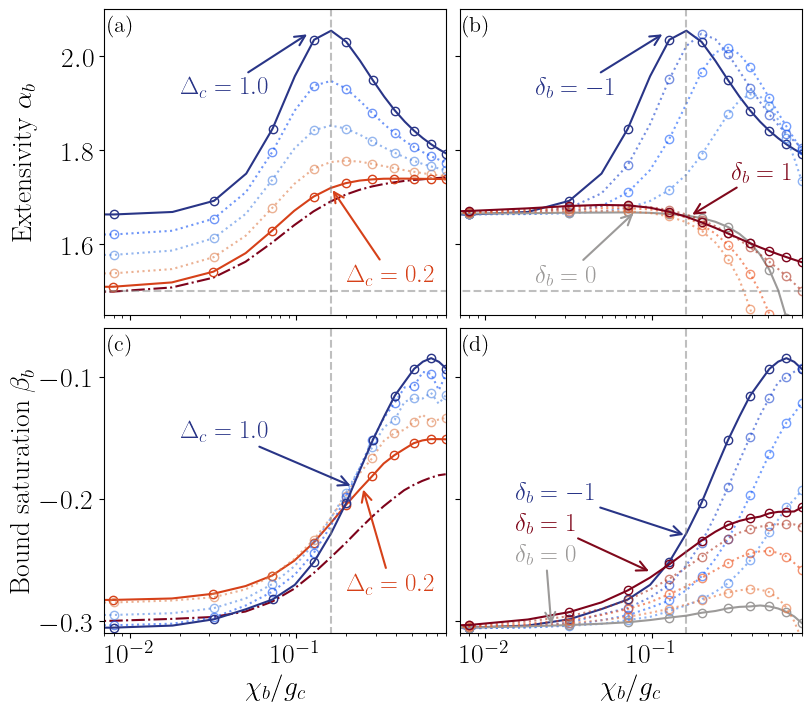

In [7]:
csv_file_ws = "qb_timeseries_fits_ws1.csv"
csv_file_an = "qb_timeseries_fits_an-1.csv"

fsize = 20
fig, axes = plt.subplots(2, 2, figsize=(8,7),sharex=True,sharey='row',layout='constrained')
axes = axes.flatten()
wsa, anw = 1.0, -1.0
npts = 1
xxx = 2

den = 0.5*len(anis_list[::])

for i,ws in enumerate([0.0,0.2,0.4,0.6,0.8,1.0]):
    result_df = extract_data_for_r(csv_file_an, ws, anw)
    gbvals = result_df['gb'].values
    Pavgmax_alpha = result_df['Pavgmax_alpha'].values
    xvals = (gbvals**2/(101-ws))/0.05
    if ws == 0.0:
        axes[0].plot(xvals, Pavgmax_alpha,linestyle='-.',color=cmap(1-ws), label=f'{ws}')
    elif ws==0.2 or ws==wsa:
        axes[0].plot(xvals, Pavgmax_alpha,linestyle='-',color=cmap(1-ws),marker='o',mfc='none',markevery=xxx, label=f'{ws}')
    else:
        axes[0].plot(xvals, Pavgmax_alpha,linestyle=':',color=cmap(1-ws),marker='o',mfc='none',markevery=xxx, label=f'{ws}', alpha=0.6)

for i,an in enumerate(anis_list[::]):
    result_df = extract_data_for_r(csv_file_ws, wsa, an)
    gbvals = result_df['gb'].values
    Pavgmax_alpha = result_df['Pavgmax_alpha'].values
    xvals = (gbvals**2/(101-wsa))/0.05
    if an in [-1,0.,1]:
        axes[1].plot(xvals, Pavgmax_alpha,linestyle='-',color=cmap(1-abs(0.5*(an-1))),marker='o',mfc='none',markevery=xxx, label=f'{an}')
    else:
        axes[1].plot(xvals, Pavgmax_alpha,linestyle=':',color=cmap(1-abs(0.5*(an-1))),marker='o',mfc='none',markevery=xxx, label=f'{an}', alpha=0.6)

for i,ws in enumerate([0.0,0.2,0.4,0.6,0.8,1.0]):
    result_df = extract_data_for_r(csv_file_an, ws, anw)
    gbvals = result_df['gb'].values
    P = result_df['Pavgmax_alpha'].values
    HB = result_df['HBavg_alpha'].values
    IE = result_df['IEavg_alpha'].values
    xvals = (gbvals**2/(101-ws))/0.05
    beta = (result_df['costh_alpha'].values)#0.5*(HB + IE) - P#
    if ws == 0.0:
        axes[2].plot(xvals, beta,linestyle='-.',color=cmap(1-ws), label=f'{ws}')
    elif ws==0.2 or ws==wsa:
        axes[2].plot(xvals, beta,linestyle='-',marker='o',color=cmap(1-ws),mfc='none',markevery=xxx, label=f'{ws}')
    else:
        axes[2].plot(xvals, beta,linestyle=':',marker='o',color=cmap(1-ws),mfc='none',markevery=xxx, label=f'{ws}', alpha=0.6)

for i,an in enumerate(anis_list[::]):
    result_df = extract_data_for_r(csv_file_ws, wsa, an)
    gbvals = result_df['gb'].values
    P = result_df['Pavgmax_alpha'].values
    HB = result_df['HBavg_alpha'].values
    IE = result_df['IEavg_alpha'].values
    beta = (result_df['costh_alpha'].values)#0.5*(HB + IE) - P#
    if an in [-1,0.,1]:
        axes[3].plot(xvals, beta,linestyle='-',marker='o',color=cmap(1-abs(0.5*(an-1))),mfc='none',markevery=xxx, label=f'{an}')
    else:
        axes[3].plot(xvals, beta,linestyle=':',marker='o',color=cmap(1-abs(0.5*(an-1))),mfc='none',markevery=xxx, label=f'{an}', alpha=0.6)

labels = ['(a)', '(b)', '(c)', '(d)']#[r'$\delta = $ {{{:.2f}}}'.format(an) for an in anis_list]
for ax, label in zip(axes, labels):
    ax.text(0.01, 0.98, label, transform=ax.transAxes, fontsize=16, 
            verticalalignment='top',)# fontweight='bold',)
            #bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.set_xlim((7e-3,0.8))
    ax.set_xscale('log')    
    if label=='(a)':
        ax.set_ylabel(r'Extensivity $\alpha_{b}$',labelpad=18)
        ax.hlines([1.5],xmin=1e-3,xmax=1e2,colors='gray',linestyle='--',alpha=0.5)
    elif label=='(c)':
        ax.set_ylabel(r'Bound saturation $\beta_{b}$')
        ax.set_xlabel(r'$\chi_{b}/g_c$')
    elif label=='(d)':
        ax.set_xlabel(r'$\chi_{b}/g_c$')
    else:
        ax.hlines([1.5],xmin=1e-3,xmax=1e2,colors='gray',linestyle='--',alpha=0.5)
    ax.vlines([0.162],ymin=-0.5,ymax=2.2,colors='gray',linestyle='--',alpha=0.5)


axes[0].annotate(
        r'$\Delta_c = {{{}}}$'.format(wsa),
        xy=(0.12, 2.05),
        xytext=(0.02, 1.92),
        fontsize=18,
        color=cmap(0),
        arrowprops=dict(arrowstyle="->",color=cmap(1-wsa), lw=1.5),
    )

axes[0].annotate(
        r'$\Delta_c = {{{}}}$'.format(0.2),
        xy=(0.162, 1.72),
        xytext=(0.2, 1.52),
        fontsize=18,
        color=cmap(0.8),
        arrowprops=dict(arrowstyle="->",color=cmap(1-0.2), lw=1.5),
    )

axes[2].annotate(
        r'$\Delta_c = {{{}}}$'.format(wsa),
        xy=(0.22, -0.19),
        xytext=(0.02, -0.15),
        fontsize=18,
        color=cmap(0),
        arrowprops=dict(arrowstyle="->",color=cmap(1-wsa), lw=1.5),
    )

axes[2].annotate(
        r'$\Delta_c = {{{}}}$'.format(0.2),
        xy=(0.25, -0.19),
        xytext=(0.2, -0.275),
        fontsize=18,
        color=cmap(1-0.2),
        arrowprops=dict(arrowstyle="->",color=cmap(1-0.2), lw=1.5),
    )

axes[1].annotate(
        r'$\delta_b = {{{}}}$'.format(-1),
        xy=(0.12, 2.05),
        xytext=(0.02, 1.92),
        fontsize=18,
        color=cmap(1-1),
        arrowprops=dict(arrowstyle="->",color=cmap(1-1), lw=1.5),
    )

axes[1].annotate(
        r'$\delta_b = {{{}}}$'.format(0),
        xy=(0.08, 1.67),
        xytext=(0.02, 1.52),
        fontsize=18,
        color=cmap(1-0.5),
        arrowprops=dict(arrowstyle="->",color=cmap(1-0.5), lw=1.5),
    )

axes[1].annotate(
        r'$\delta_b = {{{}}}$'.format(1),
        xy=(0.17, 1.66),
        xytext=(0.3, 1.74),
        fontsize=18,
        color=cmap(1-0.01),
        arrowprops=dict(arrowstyle="->",color=cmap(1-0.01), lw=1.5),
    )

axes[3].annotate(
        r'$\delta_b = {{{}}}$'.format(-1),
        xy=(0.162, -0.23),
        xytext=(0.015, -0.20),
        fontsize=18,
        color=cmap(1-1),
        arrowprops=dict(arrowstyle="->",color=cmap(1-1), lw=1.5),
    )

axes[3].annotate(
        r'$\delta_b = {{{}}}$'.format(0),
        xy=(0.025, -0.305),
        xytext=(0.015, -0.25),
        fontsize=18,
        color=cmap(1-0.5),
        arrowprops=dict(arrowstyle="->",color=cmap(1-0.5), lw=1.5),
    )

axes[3].annotate(
        r'$\delta_b = {{{}}}$'.format(1),
        xy=(0.1, -0.26),
        xytext=(0.015, -0.225),
        fontsize=18,
        color=cmap(1-0.01),
        arrowprops=dict(arrowstyle="->",color=cmap(1-0.01), lw=1.5),
    )

axes[0].set_ylim((1.45,2.1))
axes[1].set_ylim((1.45,2.1))
axes[2].set_ylim((-0.31,-0.06))
axes[3].set_ylim((-0.31,-0.06))
# axes[2].set_ylim((00.15,0.4))
# axes[3].set_ylim((0.15,0.6))

axes[2].set_yticks([-0.1,-0.2,-0.3])
axes[2].set_yticklabels([r'$-0.1$',r'$-0.2$',r'$-0.3$'])

# plt.tight_layout()
plt.savefig('Fig3.pdf',dpi=500)
plt.show()

In [8]:
xvals

array([0.   , 0.002, 0.008, 0.018, 0.032, 0.05 , 0.072, 0.098, 0.128,
       0.162, 0.2  , 0.242, 0.288, 0.338, 0.392, 0.45 , 0.512, 0.578,
       0.648, 0.722, 0.8  ])

In [9]:
decohe_file = Path("data_dict_decohe.pkl")

with decohe_file.open("rb") as fh:
    saved = pickle.load(fh)

# restore variables (fall back to existing values if keys missing)
data_dict = saved.get("data_dict", saved)
rlist = saved.get("rlist")
kappalist = saved.get("kappalist")
N = saved.get("N")
chi = saved.get("chi")
g = saved.get("g")

print(f"Loaded data_dict from {decohe_file} ({len(data_dict)} entries).")

Loaded data_dict from data_dict_decohe.pkl (20 entries).


In [10]:
from scipy import signal

def dec(x, A, B, D):
    return A * np.exp(x/B) + D

def find_env(x, y, E, distance=None, prominence=None):
    # if prominence is None:
    #     prominence = np.std(y) * 0.1
    
    min_idx, _ = signal.find_peaks(-y)

    popt, _ = curve_fit(dec, x[min_idx], E[min_idx], maxfev=10000)
    
    # linear interpolation for lower envelope
    env = dec(x, *popt)
    
    return env

In [11]:
def format_scientific(number, precision=1):
    # Format the number using the 'e' specifier
    # Example output: '1.23e+05'
    formatted_str = format(number, f'.{precision}e')
    
    # Split the string into the coefficient and the exponent part
    coefficient, exponent_part = formatted_str.split('e')

    exponent = int(exponent_part)
    return coefficient,exponent

4.7382715456822435


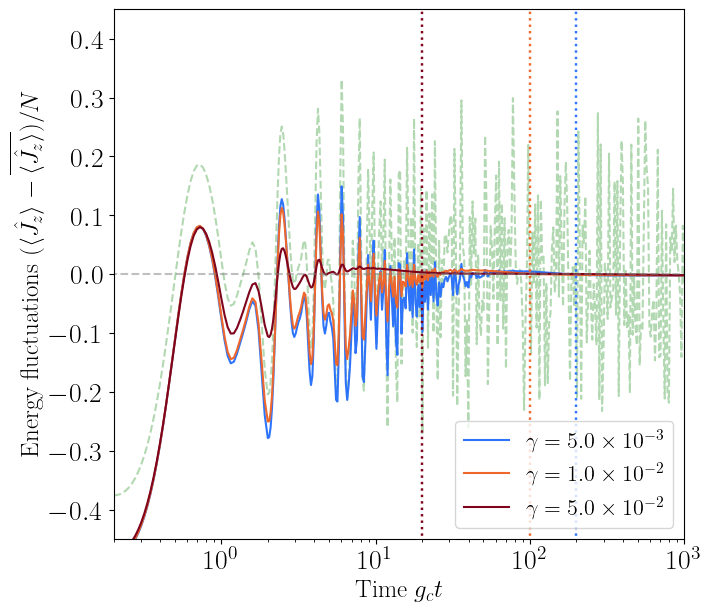

In [12]:
fig, ax = plt.subplots(figsize=(7,6),layout='constrained')

r_vals = sorted(set(k[0] for k in data_dict.keys()))
kappa_vals = sorted(set(k[1] for k in data_dict.keys()))

fsiz = 18
yn = data_dict[(r_vals[3],0.0)][1]
xn = data_dict[(r_vals[3],0.0)][0]
dEn = yn - yn[-150:].mean()#4.7382715456822435#
plt.semilogx(xn, dEn/N, color=f'green', linestyle='--',alpha=0.3)

for kpos in [2,3,4]:
    for i,r in enumerate([r_vals[3]]):
        x = data_dict[(r,kappa_vals[kpos])][0]
        y = data_dict[(r,kappa_vals[kpos])][1]

        dE = y - y[-150:].mean()
        # env = find_env(x, dE/N, y/N)
        coeff, expo = format_scientific(kappa_vals[kpos])
        plt.semilogx(x, dE/N, color=cmap((kpos-1)/3), label=r"$\gamma={{{}}}\times 10^{{{}}}$".format(coeff,expo),alpha=1)
        # plt.semilogx(x, env, color=cmap((kpos-1)/4), linestyle=':', alpha=1.)
print(y[-150:].mean())

ax.hlines([0.],xmin=1e-5,xmax=1e5, color='gray', linestyle='--', alpha=0.5)
ax.vlines([200.],ymin=-.5,ymax=.5, color=cmap((2-1)/3), linestyle=':', alpha=0.99,linewidth=1.75)
ax.vlines([100.],ymin=-.5,ymax=.5, color=cmap((3-1)/3), linestyle=':', alpha=0.99,linewidth=1.75)
ax.vlines([20.],ymin=-.5,ymax=.5, color=cmap((4-1)/3), linestyle=':', alpha=0.99,linewidth=1.75)
ax.set_xlabel(r'Time $g_ct$',fontsize=fsiz)
ax.set_ylabel(r"Energy fluctuations $(\langle \hat{J}_z \rangle - \overline{\langle \hat{J}_z \rangle})/N$",fontsize=fsiz)
ax.set_xlim((2e-1, 1e3))
ax.set_ylim((-0.45, 0.45))

plt.legend(fontsize=fsiz-2)
# plt.tight_layout()
plt.savefig('Fig4.pdf', dpi=300)
plt.show()

In [13]:
# decohe_file = Path("data_dict_inhomo.pkl")

# with decohe_file.open("rb") as fh:
#     saved = pickle.load(fh)

# # restore variables (fall back to existing values if keys missing)
# data_dict = saved.get("data_dict", saved)
# rlist = saved.get("rlist")
# sigmalist = saved.get("sigmalist")
# N = saved.get("N")
# chi = saved.get("chi")
# g = saved.get("g")

# print(f"Loaded data_dict from {decohe_file} ({len(data_dict)} entries).")

In [14]:
from matplotlib.patches import Rectangle, ConnectionPatch
def indicate_inset(axin, axout, arrow_start=(0, 0), arrow_end=(0, 0)):
    (x0, x1), (y0, y1) = axin.get_xlim(), axin.get_ylim()
    width = x1 - x0
    height = y1 - y0
    
    rect = Rectangle(
        [x0, y0], width=width, height=height, 
        transform=axout.transData, fc='none', ec='red'
    )
    axout.add_patch(rect)
    
    conn = ConnectionPatch(
        xyA=arrow_start, coordsA=rect.get_transform(),
        xyB=arrow_end, coordsB=axin.transAxes,
        arrowstyle='-',color='red',alpha=0.5, 
    )
    fig.add_artist(conn)
    return rect, conn

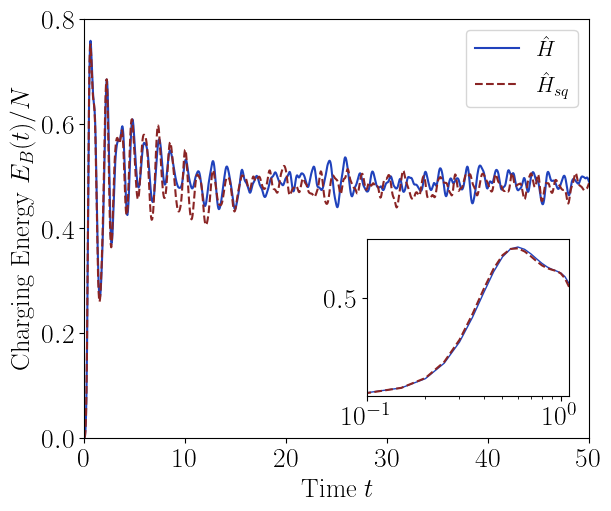

In [15]:
fig, ax = plt.subplots(figsize=(6,5), layout='constrained')

FullDy = qload("FullModel_N100")
SWDy = qload("SWModel_N100")

Vnrm = 1#2*2.0*np.sqrt(100)/(np.pi)

tF = np.array(FullDy.times[:]) * Vnrm
tS = np.array(SWDy.times[:]) * Vnrm

EF = FullDy.expect[0]
ES = SWDy.expect[0]

# inset axes (zoom)
x1, x2, y1, y2 = 0.1, 1., 0, 0.8
axins = ax.inset_axes([28, 0.08, 20, 0.3], transform=ax.transData, xlim=(x1,x2), ylim=(y1,y2), yticks=[0.5], xticks=[0.1, 1.1],zorder=5)
axins.plot(tF, EF, linewidth=1, color=cmap(0.1))
axins.plot(tS, ES, linestyle='--', linewidth=1.5, color=cmap(0.95))
axins.set_xscale('log')
# ax.indicate_inset_zoom(axins, edgecolor="black", zorder=2)
# indicate_inset(axins, ax, arrow_start=(1, 0), arrow_end=(0, 0))


ax.plot(tF, EF, label=r'$\hat{H}$', color=cmap(0.1))
ax.plot(tS, ES, label=r'$\hat{H}_{sq}$', linestyle='--', color=cmap(0.95))
ax.set_xlabel(r'Time $t$',fontsize=fsiz+1)
ax.set_ylabel(r"Charging Energy $E_B(t)/N$",fontsize=fsiz+1)
ax.set_xlim(0,50)
ax.set_ylim((0, 0.8))
# ax.set_xscale('log')
plt.legend(fontsize=fsiz-2)
plt.savefig('FigA1.pdf', dpi=300)
plt.show()

In [16]:
fsiz

18